In [1]:
import sys
import os
sys.path.append("..")
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer
from numpyro_ext import distributions as distx
from numpyro_ext import info, optim
numpyro.set_host_device_count(2)  # For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update("jax_enable_x64", True)
#jax.config.update('jax_disable_jit', True)
from jaxoplanet import light_curves, orbits
from jaxoplanet.light_curves import limb_dark_light_curve
import arviz as az
import corner
from eclipsoid.light_curve import legacy_oblate_lightcurve, compute_bounds
import os
import pandas as pd
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"
oblate_lightcurve = jit(legacy_oblate_lightcurve)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


{'period': 7.704045333151538, 't0': 1.0, 'radius': 0.1446, 'bo': 0.01, 'u': Array([0.3, 0.2], dtype=float64), 'f': 0.1, 'theta': 0.6108652381980153, 'duration': 0.12}


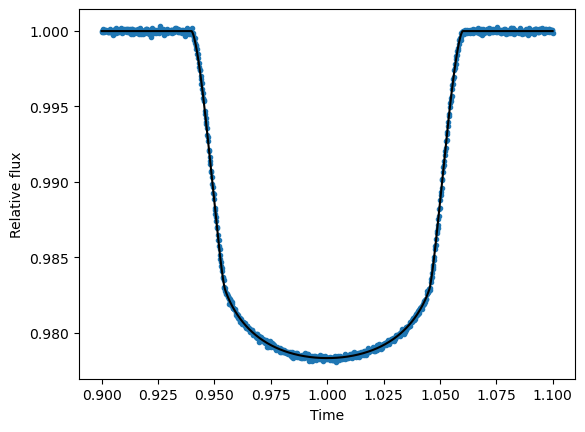

In [2]:
np.random.seed(11)
period_true = np.random.uniform(5, 20)
t = np.linspace(0.9,1.1,1000)
yerr = 100*1e-6

true_params = {'period':period_true,
               't0':1.0,
                'radius':0.1446,
                'bo':0.01,
                'u':jnp.array([0.3, 0.2]),
                'f':0.1,
                'theta':np.radians(35),
                'duration': 0.12
} 

print(true_params)

# Compute a limb-darkened light curve using starry
lc_true = oblate_lightcurve(true_params, t-true_params['t0'])

lc = lc_true + yerr*np.random.normal(size=len(t))

ax = plt.subplot()
ax.plot(t, lc, 'C0.')
ax.plot(t, lc_true, color='k')
ax.set_ylabel("Relative flux")
ax.set_xlabel("Time");

In [3]:
def q_to_u(q1, q2): 
    u1 = 2.*jnp.sqrt(jnp.abs(q1))*q2
    u2 = jnp.sqrt(jnp.abs(q1))*(1-(2*q2))
    return jnp.array([u1,u2])
def model(t, yerr, y=None):
    # If we wanted to fit for all the parameters, we could use the following,
    # but we'll keep these fixed for simplicity.
    
    #log_duration = numpyro.sample("log_duration", dist.Uniform(jnp.log(0.08), jnp.log(0.2)))
    #b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    #log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(yerr), 1.0))
    r_circ = numpyro.sample("r_circ", dist.Uniform(0.01, 0.2))
    q1 = numpyro.sample("q1", dist.Uniform(0.0, 1.0))
    q2 = numpyro.sample("q2", dist.Uniform(0.0, 1.0))
    u = numpyro.deterministic("u",q_to_u(q1, q2))
    bo = numpyro.sample("bo", dist.Uniform(0.0,1.))
    
    #parametrize f, theta using a unit disk
    f = numpyro.sample("f", dist.Uniform(0.0, 1.0))
    theta = numpyro.sample("theta", dist.Uniform(0.0, jnp.pi))
    hk = numpyro.deterministic('hk',jnp.array([jnp.sqrt(f/2.)*2.*jnp.cos(2.*theta),jnp.sqrt(f/2.)*2.*jnp.sin(2.*theta)]))

    # The duration
    log_d = numpyro.sample("log_d", numpyro.distributions.Normal(jnp.log(0.12), 0.01))
    duration = numpyro.deterministic("duration", jnp.exp(log_d))
    
    params = {
        'period':period_true,
        't0': 1.0,
        "radius": jnp.sqrt(r_circ**2/(1-f)),
        'bo':bo,
        'u': u,
        'f':f, 
        'theta':theta,
        'duration': duration
    }
    y_pred = oblate_lightcurve(params, t-params['t0'])
    numpyro.deterministic("light_curve", y_pred)
    numpyro.sample(
        "flux",
        dist.Normal(y_pred, jnp.sqrt(yerr**2) #+ jnp.exp(2 * log_jitter))
                    ),
        obs=y,
    )

In [12]:
from numpyro.contrib.nested_sampling import NestedSampler

In [13]:
ns = NestedSampler(model, constructor_kwargs={'num_parallel_workers':2})
ns.run(jax.random.PRNGKey(2), t, yerr, lc)

ns_samples = ns.get_samples(jax.random.PRNGKey(121), num_samples=10000)

INFO:jaxns:Number of parallel Markov-chains set to: 175
INFO:jaxns:Using 2 parallel workers, each running identical samplers.
E0530 11:45:50.823602 1635156 collective_ops_utils.h:269] This thread has been waiting for 5000ms for and may be stuck: participant AllGatherParticipantData{rank=0, devices=[0, 1], source_buffer=0x36b6a2d10, destination_buffer=0x36b4fc000, chunk_size=8} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1806, global_devices=[0,1], num_local_participants=2, collective_op_kind=cross_replica, op_id=63}
E0530 11:47:18.890331 1635156 collective_ops_utils.h:272] Thread is unstuck! Warning above was a false-positive. Perhaps the timeout is too short: participant AllGatherParticipantData{rank=0, devices=[0, 1], source_buffer=0x36b6a2d10, destination_buffer=0x36b4fc000, chunk_size=8} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1806, global_devices=[0,1], num_local_participants=2, collective_op_kind=cross_

In [23]:
ns_samples_for_az = {k: v[jnp.newaxis, :] for k, v in ns_samples.items() if k != "light_curve"}

In [25]:
inf_data_ns = az.convert_to_inference_data(ns_samples_for_az)

In [30]:
inf_data_ns.to_netcdf("average_radius_NS_100ppm_bo_0.01.h5")

'average_radius_NS_100ppm_bo_0.01.h5'

In [26]:
az.summary(inf_data_ns, var_names=['r_circ', 'bo', 'u', 'f', 'theta', 'duration'])

/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r_circ,0.137,0.000,0.137,0.138,0.000,0.000,9927.0,9447.0,NaN
bo,0.129,0.075,0.000,0.243,0.001,0.001,9834.0,9722.0,NaN
u[0],0.301,0.006,0.290,0.312,0.000,0.000,9875.0,9792.0,NaN
u[1],0.200,0.014,0.177,0.227,0.000,0.000,9873.0,9850.0,NaN
f,0.080,0.090,0.000,0.282,0.001,0.001,9545.0,9488.0,NaN
theta,1.071,0.450,0.392,1.796,0.004,0.003,10042.0,10000.0,NaN
duration,0.120,0.000,0.120,0.121,0.000,0.000,9828.0,9971.0,NaN


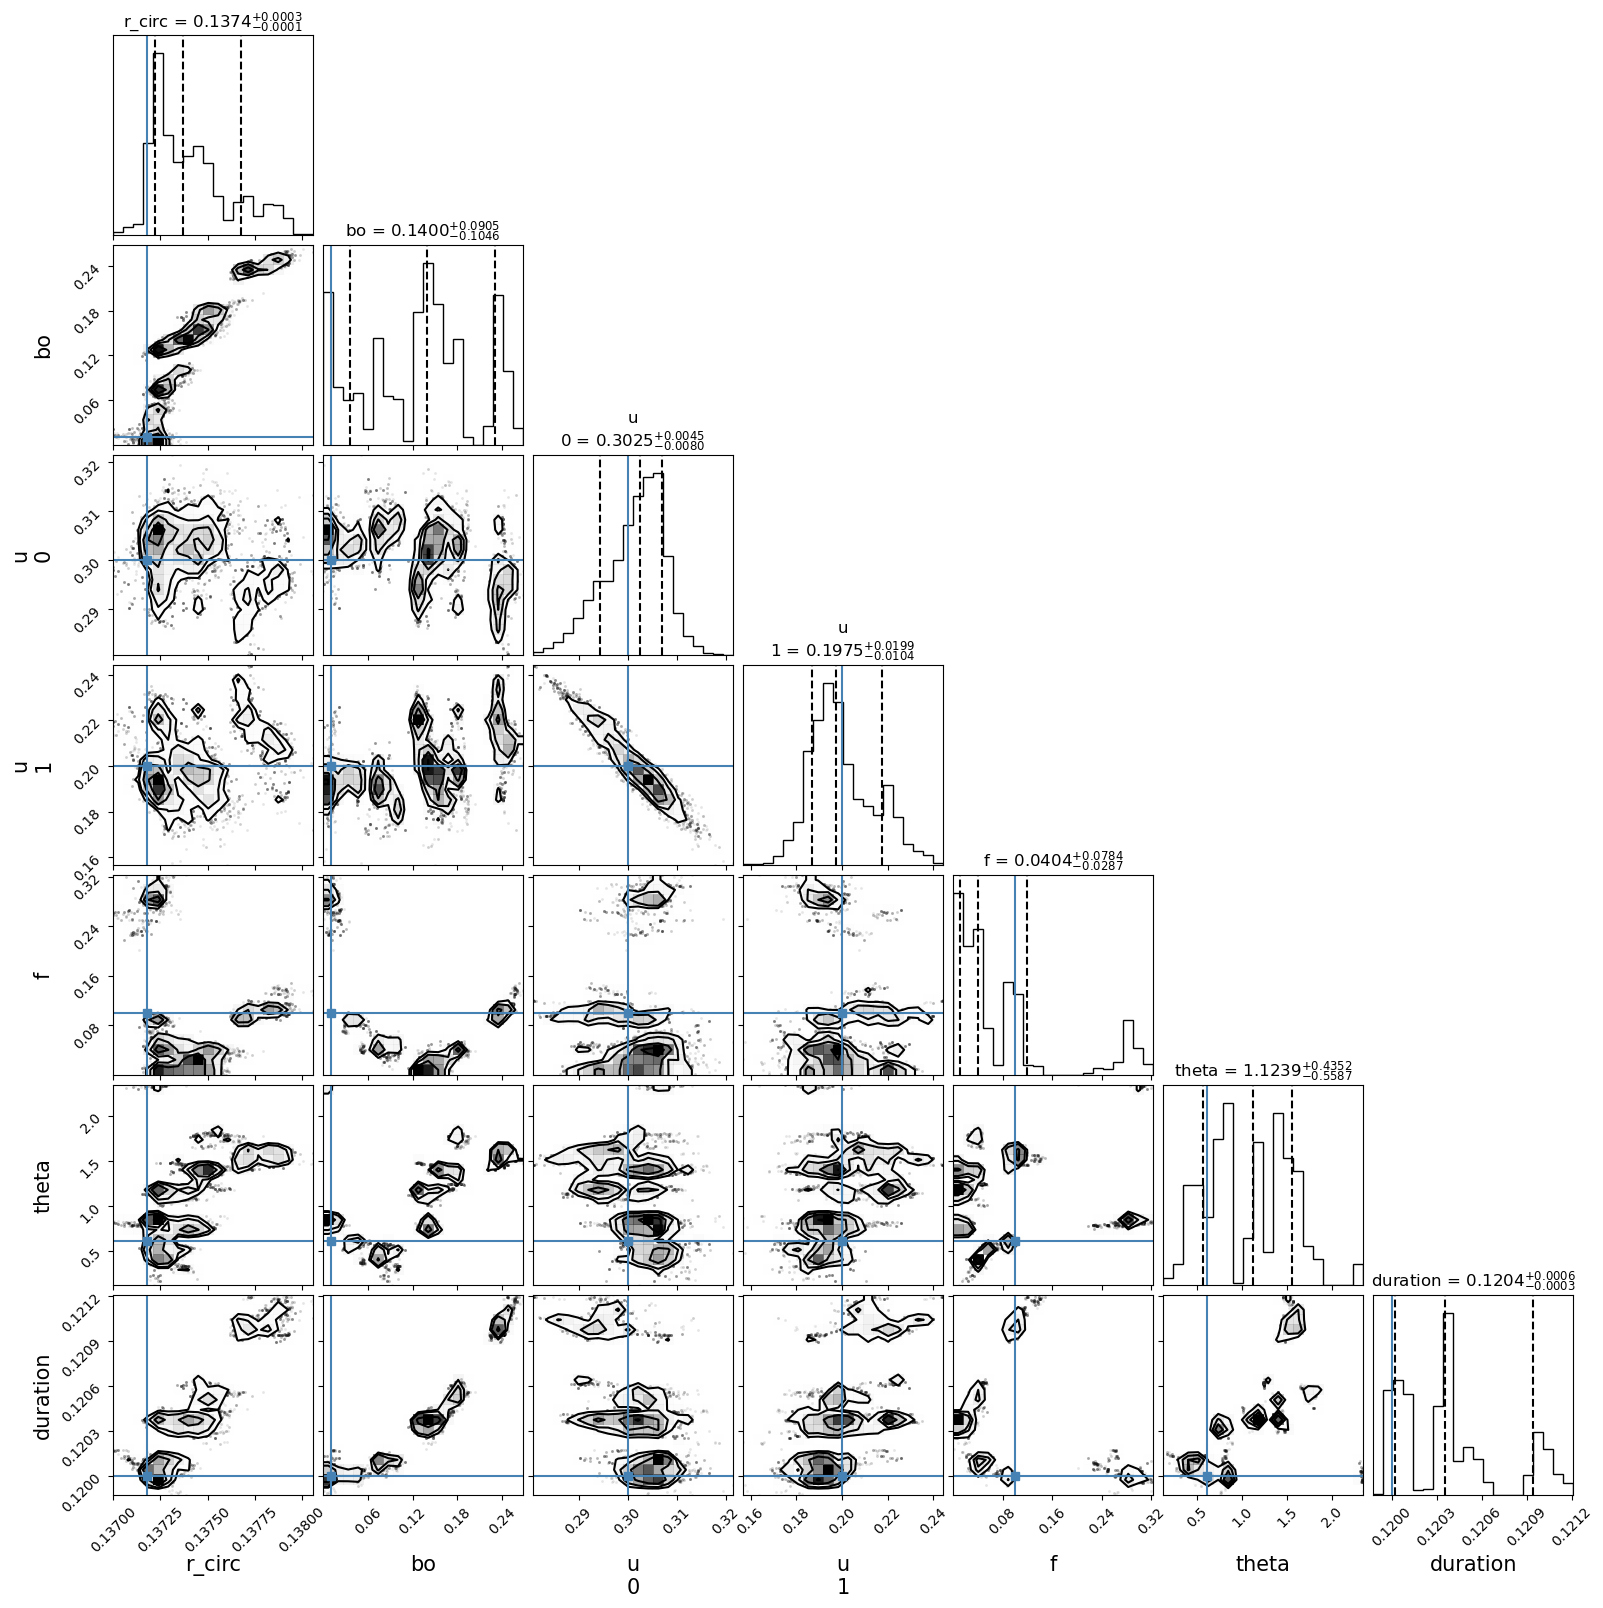

In [27]:
corner.corner(
    inf_data_ns,
    var_names=['r_circ', 'bo', 'u', 'f','theta', 'duration'],
    truths=[np.sqrt(true_params['radius']**2*(1-true_params['f'])), true_params['bo'], true_params['u'][0], true_params['u'][1], true_params['f'], true_params['theta'], true_params['duration']],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 15},
    title_fmt=".4f",
);